In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

# # Useful for plotting graphs
import matplotlib.pyplot as plt
from seaborn import scatterplot

from sklearn.linear_model import LinearRegression

# # Intent for data exploration
from pandas.plotting import scatter_matrix
from seaborn import scatterplot

# # Important in order to create a test set
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import OneHotEncoder

# # For feature engineering
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_absolute_error

from joblib import dump

from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

from seaborn import lmplot, stripplot





# Read in and Check the Data
#### I also shuffle the dataset which will ensure randomisation

In [3]:
df = pd.read_csv('dataset_vehicles.csv')

df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

#### Summary Statistics

In [4]:
df.describe(include="all")

,Title,Sub_title,Price,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity,Mileage,Location,Description,Post_URL,Seller_name,Seller_type,published_date
count,18938,18938,18938,18938,18938,13908,18938.000000,18938,18938,17043,18938,18938,18938,18938,18938,18938,18938,18938,18938
unique,10329,17014,1831,57,516,6336,NaN,3,4,7,6,432,3850,198,17075,17911,6103,1,15060
top,Suzuki Alto 2015 for sale,"Posted on 03 Mar 11:21 am, Colombo 3, Colombo","Rs 650,000",Toyota,Alto,G Grade,NaN,Used,Automatic,Hatchback,Petrol,"1,500 cc","100,000 km","Kohuwala, Colombo",* Leasing can be arranged with your requiremen...,https://ikman.lk/en/ad/toyota-pixis-g-intelige...,LB Finance PLC,Premium-Member,2021-03-03 11:21:00
freq,184,63,92,5762,962,172,NaN,17991,11412,6712,13823,3861,450,1333,151,4,512,18938,69
mean,NaN,NaN,NaN,NaN,NaN,NaN,2007.718344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,11.640139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1927.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2003.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Checking all the columns in the dataset

In [5]:
df.columns

Index(['Title', 'Sub_title', 'Price', 'Brand', 'Model', 'Edition', 'Year',
       'Condition', 'Transmission', 'Body', 'Fuel', 'Capacity', 'Mileage',
       'Location', 'Description', 'Post_URL', 'Seller_name', 'Seller_type',
       'published_date'],
      dtype='object')

#### This checks to see how many items are in the dataset

In [6]:
df.index

RangeIndex(start=0, stop=18938, step=1)

#### Illustrating the dimensions of the dataframe. 18938 rows, 19 columns. Shape can be used to determine whether we should use K fold or Holdout. In this case it would be Holdout as it is a large dataset. 

In [7]:
df.shape

(18938, 19)

#### Showcasing the datatypes. Notice how there is only 1 integer, the rest are strings. It is clear that I need to convert some objects to integers

In [8]:
df.dtypes

Title             object
Sub_title         object
Price             object
Brand             object
Model             object
Edition           object
Year               int64
Condition         object
Transmission      object
Body              object
Fuel              object
Capacity          object
Mileage           object
Location          object
Description       object
Post_URL          object
Seller_name       object
Seller_type       object
published_date    object
dtype: object

#### Visual representation of the dataframe. Initial reaction indicates that the dataframe needs to be cleaned. Only showing a few rows to minimise leakage

In [9]:
df.head()

,Title,Sub_title,Price,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity,Mileage,Location,Description,Post_URL,Seller_name,Seller_type,published_date
0,Honda Fit Shuttle Full Option 2015 for sale,"Posted on 30 May 2:39 pm, Alutgama, Kalutara","Rs 5,600,000",Honda,Fit Shuttle,Full Option,2015,Used,Automatic,Station wagon,Hybrid,"1,490 cc","107,222 km","Alutgama, Kalutara","HONDA FIT SHUTTLE GP7Rs. 5,600,000/= (Negotiab...",https://ikman.lk/en/ad/honda-fit-shuttle-full-...,kasun,Premium-Member,2021-05-30 14:39:00
1,Kia Sorento 1 to 12 tan premium 2011 for sale,"Posted on 18 Jun 4:01 pm, Horana, Kalutara","Rs 9,800,000",Kia,Sorento,1 to 12 tan premium,2011,Used,Automatic,SUV / 4x4,Diesel,"2,200 cc","114,586 km","Horana, Kalutara",sorento tan primium 1 -12 option engineer used...,https://ikman.lk/en/ad/kia-sorento-1-to-12-tan...,Thilina Chamara,Premium-Member,2021-06-18 16:01:00
2,Suzuki Estilo Zen 2010 for sale,"Posted on 17 Mar 3:19 pm, Kuliyapitiya, Kurune...","Rs 2,175,000",Suzuki,Estilo,Zen Estilo,2010,Used,Manual,Hatchback,Petrol,"1,000 cc","134,000 km","Kuliyapitiya, Kurunegala",New Tyres... New Battery ...Power Shutters..Po...,https://ikman.lk/en/ad/suzuki-estilo-zen-2010-...,Malith Welandage,Premium-Member,2021-03-17 15:19:00
3,Micro MX 7 Mark 2 2013 for sale,"Posted on 24 Jul 5:40 pm, Kottawa, Colombo","Rs 2,350,000",Micro,MX 7,Mark 2,2013,Used,Manual,Saloon,Petrol,"1,500 cc","45,000 km","Kottawa, Colombo",Motor CarRegistered on 2013 December First Owner,https://ikman.lk/en/ad/micro-mx-7-mark-2-2013-...,Ravi Hettiarachchi,Premium-Member,2021-07-24 17:40:00
4,Toyota Harrier LEXUS 2002 for sale,"Posted on 23 Jul 8:32 pm, Negombo, Gampaha","Rs 5,390,000",Toyota,Harrier,LEXUS,2002,Used,Automatic,SUV / 4x4,Petrol,"2,000 cc","170,000 km","Negombo, Gampaha",20023RD OWNERTOYOTA COMPANY MAINTAIN LEATHER E...,https://ikman.lk/en/ad/toyota-harrier-lexus-20...,NIROSHAN MOTOR TRADERS,Premium-Member,2021-07-23 20:32:00


#### Taking a copy of the df incase I make a big error, I still have the original

In [10]:
df1 = df.copy()

# Data Cleaning
#### This includes converting objects to integers and removing outliers

#### Removing "Rs" from the price. Removing the comma so it can be converted to an integer. Converting to integer

In [11]:
df1['Price'] = df1['Price'].str.replace('Rs', '')
df1["Price"] = df1["Price"].str.replace(',', '')
df1["Price"] = df1["Price"].astype(int)

#### Renaming Mileage to Mileage_km so I can extract km in the data to make the values an integer. The reason for renaiming is, so when the value is gone, future readers will understand from the title what it is measured in. The user could eaily think it is miles instead of km as some countries use different measurements

In [12]:
df1 = df1.rename(columns={'Mileage':'Mileage_km'})

#### Now it is time to remove "km: in the values. Removing the comma so it can be converted to an integer. Converting to integer

In [13]:
df1["Mileage_km"] = df1["Mileage_km"].str.replace('km', '')
df1["Mileage_km"] = df1["Mileage_km"].str.replace(',', '')
df1["Mileage_km"] = df1["Mileage_km"].astype(int)

#### Renaming Capacity to Capacity so I can extract cc in the data to make it an integer. The reason for renaiming is so when the value is gone future readers will understand from the title what it is measured in. In this case it is measured in cc



In [14]:
df1 = df1.rename(columns={'Capacity':'Capacity_cc'})

#### Removing "cc" from the capacity column. Removing the comma so it can be converted to an integer. Converting to integer

In [15]:
df1["Capacity_cc"] = df1["Capacity_cc"].str.replace('cc', '')
df1["Capacity_cc"] = df1["Capacity_cc"].str.replace(',', '')
df1["Capacity_cc"] = df1["Capacity_cc"].astype(int)

#### Demonstrating that I have converted the objects/strings that should be integers, into integers

In [16]:
df1.dtypes

Title             object
Sub_title         object
Price              int64
Brand             object
Model             object
Edition           object
Year               int64
Condition         object
Transmission      object
Body              object
Fuel              object
Capacity_cc        int64
Mileage_km         int64
Location          object
Description       object
Post_URL          object
Seller_name       object
Seller_type       object
published_date    object
dtype: object

#### Checking to see if my conversions have worked on the data visually. Only showing head to minimise leakage

In [17]:
df1.head()

,Title,Sub_title,Price,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity_cc,Mileage_km,Location,Description,Post_URL,Seller_name,Seller_type,published_date
0,Honda Fit Shuttle Full Option 2015 for sale,"Posted on 30 May 2:39 pm, Alutgama, Kalutara",5600000,Honda,Fit Shuttle,Full Option,2015,Used,Automatic,Station wagon,Hybrid,1490,107222,"Alutgama, Kalutara","HONDA FIT SHUTTLE GP7Rs. 5,600,000/= (Negotiab...",https://ikman.lk/en/ad/honda-fit-shuttle-full-...,kasun,Premium-Member,2021-05-30 14:39:00
1,Kia Sorento 1 to 12 tan premium 2011 for sale,"Posted on 18 Jun 4:01 pm, Horana, Kalutara",9800000,Kia,Sorento,1 to 12 tan premium,2011,Used,Automatic,SUV / 4x4,Diesel,2200,114586,"Horana, Kalutara",sorento tan primium 1 -12 option engineer used...,https://ikman.lk/en/ad/kia-sorento-1-to-12-tan...,Thilina Chamara,Premium-Member,2021-06-18 16:01:00
2,Suzuki Estilo Zen 2010 for sale,"Posted on 17 Mar 3:19 pm, Kuliyapitiya, Kurune...",2175000,Suzuki,Estilo,Zen Estilo,2010,Used,Manual,Hatchback,Petrol,1000,134000,"Kuliyapitiya, Kurunegala",New Tyres... New Battery ...Power Shutters..Po...,https://ikman.lk/en/ad/suzuki-estilo-zen-2010-...,Malith Welandage,Premium-Member,2021-03-17 15:19:00
3,Micro MX 7 Mark 2 2013 for sale,"Posted on 24 Jul 5:40 pm, Kottawa, Colombo",2350000,Micro,MX 7,Mark 2,2013,Used,Manual,Saloon,Petrol,1500,45000,"Kottawa, Colombo",Motor CarRegistered on 2013 December First Owner,https://ikman.lk/en/ad/micro-mx-7-mark-2-2013-...,Ravi Hettiarachchi,Premium-Member,2021-07-24 17:40:00
4,Toyota Harrier LEXUS 2002 for sale,"Posted on 23 Jul 8:32 pm, Negombo, Gampaha",5390000,Toyota,Harrier,LEXUS,2002,Used,Automatic,SUV / 4x4,Petrol,2000,170000,"Negombo, Gampaha",20023RD OWNERTOYOTA COMPANY MAINTAIN LEATHER E...,https://ikman.lk/en/ad/toyota-harrier-lexus-20...,NIROSHAN MOTOR TRADERS,Premium-Member,2021-07-23 20:32:00


#### Check for NaN in the case of the target values. It is False so nothing further needs to be done. 



In [18]:
df1["Price"].isnull().values.any()

False

#### Creating lists of features dedicated to their data type to make it easy to search through them and find things like outliers. Excluding certain features as they are irrelevant and I do not want to mindlessly one-hot-encode them. I have excluded certain features in the features list as it increases my error when I one-hot-encode them. Therefore, I only have numeric features in my feature list

In [19]:
numeric_features = ["Year", "Capacity_cc", "Mileage_km"]
nominal_features = ["Condition", "Transmission", "Fuel"]
features = ["Year", "Capacity_cc", "Mileage_km"]

#### The values, in the case of numerical-valued features. Checking these values to see if there are any outliers. It is clear that there are many outliers here. For capacity, it is impossible for an engine to have a size of 1, 2, 3cc etc. These values need to be removed.

In [20]:
for feature in numeric_features:
    print(feature, df1[feature].unique())

Year [2015 2011 2010 2013 2002 2004 2000 2018 2012 2017 1984 2001 1982 2016
 1989 2007 1985 1998 1987 1986 1999 2005 2014 2008 1994 1997 1976 2019
 2006 1977 1988 2003 1991 1983 1992 1960 2020 1995 1993 1996 1971 1980
 2009 1973 1965 1978 1975 2021 1958 1979 1970 1956 1974 1981 1990 1946
 1969 1972 1963 1967 1957 1959 1950 1953 1938 1955 1961 1968 1952 1936
 1947 1964 1966 1945 1935 1927]
Capacity_cc [ 1490  2200  1000  1500  2000   800   650  3000  1300  1400  1800   660
  4700  1330  1298  1991    70  1600  1830  1680  1200  2500  2700  1290
  1580  1956  1970   999  2800  2494  4200  1495   600  1295  2400  1499
   658   998  3200  2952  2900  2490  1597   640  1598  1480  1450  2498
   990  3500  2362  2690   880  3100  4500  1320  3250  3600  1790  2143
   250  1240  2993   850  4660  1359  2183  2179  2300  2600  1980  2450
   812   400   798   625   993  3400  1100  1171  1270   980  1990  1950
  1587   216  2680  1750   210   989  3498  1998  2550  2180  1398  2980
  2460  1590

#### Illustrating how many rows and columns are in the dataframe before I start deleting outliers

In [21]:
df1.shape

(18938, 19)

#### Checking to see what certain features look like on graphs and also checking to see where the outliers lie

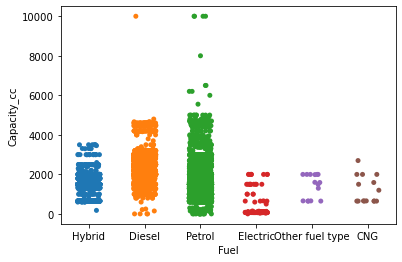

In [22]:
plot = stripplot(x="Fuel", y="Capacity_cc", data=df1, jitter=0.2)

#### Delete examples whose Capacity is too small and too big. Selected these numbers from research on the web as to what the engine cc should be and by also looking at outliers on the graph



In [23]:
df1 = (df1[(df1["Capacity_cc"] >= 300) & (df1["Capacity_cc"] < 7000)]).copy()

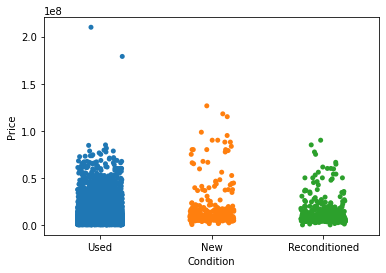

In [24]:
plot = stripplot(x="Condition", y="Price", data=df1, jitter=0.2)

#### Delete examples whose prices are too low and too high. 50000 value was decided through research into Sri Lankin car websites by checking the lowest price of a used car and seeing what the outliers were on the graphs. 158000000 was decided from finding out how much the most expensive car in sri lanka costs. No car exceeds this figure in Sri Lanka







In [25]:
df1 = (df1[(df1["Price"] > 50000) & (df1['Price'] <= 158000000)]).copy()

#### Illustrating that the examples have been deleted. If you look at the y-axis, it has narrowed down the range. This is why it may look like the "New Condition" chart has grown

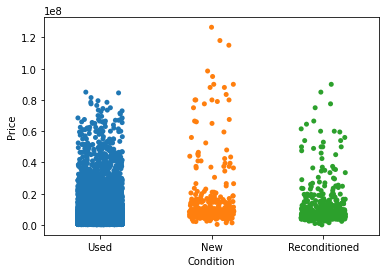

In [26]:
plot = stripplot(x="Condition", y="Price", data=df1, jitter=0.2)

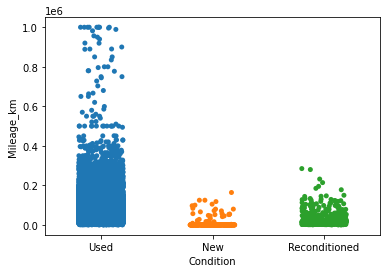

In [27]:
plot = stripplot(x="Condition", y="Mileage_km", data=df1, jitter=0.2)

#### Thinking of deleting used cars that have extremely low mileage but realised that there is no way of proving that they were not dirven


In [28]:
df2 = (df1[(df1["Mileage_km"] < 100) & (df1['Condition'] == 'Used')]).copy()

#### From my research, a cars life expectancy is 200,000 km. Taking engine replacemnents into account I have over doubled this figure to eliminate outliers. 



In [29]:
df1 = (df1[(df1['Mileage_km'] < 500000)]).copy()

#### Reset the index

In [30]:
df1.reset_index(drop=True, inplace=True)

#### Check shape after deletion

In [31]:
df1.shape

(18703, 19)

# Creating a Test Set
#### Creating test set before data exploration so there is no leakage



In [32]:
dev_df1, test_df1 = train_test_split(df1, train_size=0.8, random_state=2)

# Extract the features but leave as a DataFrame
dev_X = dev_df1[features]
test_X = test_df1[features]

# Target values, converted to a 1D numpy array
dev_y = dev_df1["Price"].values
test_y = test_df1["Price"].values

#### It can be good to do this on a copy of the dataset, excluding the test set 

In [33]:
copy_df1 = dev_df1.copy()

# Data Exploration

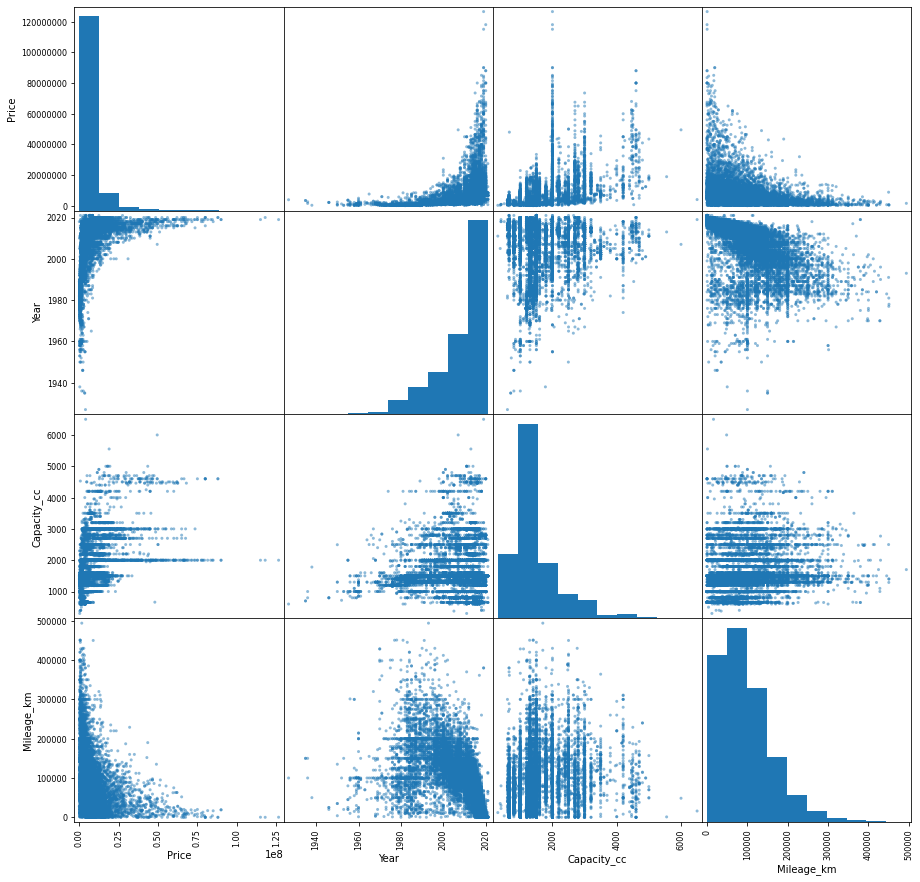

In [34]:
m = scatter_matrix(copy_df1, figsize=(15, 15))

#### Investigation into the price of vehicles. As expected, Manual cars price is low

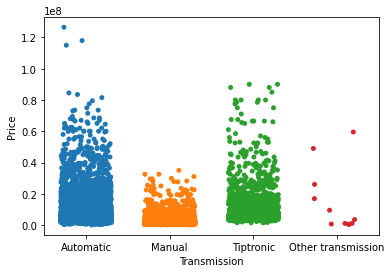

In [35]:
plot = stripplot(x="Transmission", y="Price", data=copy_df1, jitter=0.3)

#### Attempting to do logs on graphs to see if any interesting changes are made. Attempting features like these for feature engineering

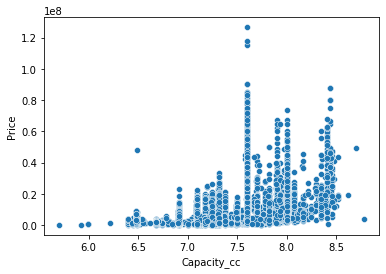

In [36]:
df4 = copy_df1.copy()
df4['Capacity_cc'] = np.log(copy_df1['Capacity_cc'])
plot = scatterplot(x="Capacity_cc", y="Price", data=df4)

#### Illustrating the correlations between the numeric valued columns before feature engineering is performed

In [37]:
copy_df1.corr()

,Price,Year,Capacity_cc,Mileage_km
Price,1.000000,0.359094,0.496434,-0.295133
Year,0.359094,1.000000,-0.084807,-0.552291
Capacity_cc,0.496434,-0.084807,1.000000,0.219190
Mileage_km,-0.295133,-0.552291,0.219190,1.000000


# Feature Engineering

In [38]:
# copy_df1['ycmr'] = (copy_df1["Capacity_cc"] + copy_df1["Year"]) - copy_df1["Mileage_km"]
# copy_df1['ycr'] = copy_df1["Year"] + np.log(copy_df1['Capacity_cc'])
# copy_df1['ycr'] = copy_df1["Capacity_cc"]
copy_df1['ycr'] = (copy_df1["Capacity_cc"] + copy_df1["Year"])




#### Plotting my new feature against price to get a visualisation of the correlation

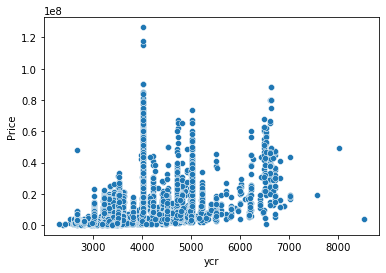

In [39]:
plot = scatterplot(x="ycr", y="Price", data=copy_df1)

#### Checking the correlations between the standard features and the new features I have created

In [40]:
copy_df1.corr()

,Price,Year,Capacity_cc,Mileage_km,ycr
Price,1.000000,0.359094,0.496434,-0.295133,0.502857
Year,0.359094,1.000000,-0.084807,-0.552291,-0.068741
Capacity_cc,0.496434,-0.084807,1.000000,0.219190,0.999870
Mileage_km,-0.295133,-0.552291,0.219190,1.000000,0.210531
ycr,0.502857,-0.068741,0.999870,0.210531,1.000000


#### Writing a class based on the new features created

In [41]:
class InsertYCR(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X['ycr'] = X['Capacity_cc'] + X['Year']  
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X


In [42]:
class TransformerFromHyperP(BaseEstimator, TransformerMixin):

    def __init__(self, transformer=None):
        self.transformer = transformer
        
    def fit(self, X, y=None):
        if self.transformer:
            self.transformer.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        if self.transformer:
            return self.transformer.transform(X)
        else:
            return X

# Preprocessor
#### I discovered that one-hot-enoding suprisingly ended up increasing my prediction error so I left that out

In [43]:
preprocessor = ColumnTransformer([
        ("num", Pipeline([("ycr", InsertYCR()),
                          ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                          ("scaler", TransformerFromHyperP())]), 
                numeric_features)]
    ,remainder="passthrough")


#         ("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), 
#                           ("binarizer", OneHotEncoder(handle_unknown="ignore"))]), 
#                 nominal_features)],

# Ridge Regression

In [44]:
# Create a pipeline that combines the preprocessor with ridge regression
ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", Ridge())])

# Create a dictionary of hyperparameters for ridge regression
ridge_param_grid = {"preprocessor__num__ycr__insert": [True, False],
                     "preprocessor__num__scaler__transformer": [StandardScaler(), MinMaxScaler(), RobustScaler()],
                     "predictor__alpha": [80.0, 85.0, 90.0, 95.0, 100.0]}

# Create the grid search object which will find the best hyperparameter values based on validation error
ridge_gs = GridSearchCV(ridge, ridge_param_grid, scoring="neg_mean_absolute_error", cv=10)

# Run grid search by calling fit
ridge_gs.fit(dev_X, dev_y)

# Let's see how well we did
ridge_gs.best_params_, ridge_gs.best_score_

({'predictor__alpha': 90.0,
  'preprocessor__num__scaler__transformer': MinMaxScaler(),
  'preprocessor__num__ycr__insert': True},
 -3113254.5756606357)

In [45]:
ridge.set_params(**ridge_gs.best_params_) 
scores = cross_validate(ridge, dev_X, dev_y, cv=10, 
                        scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  3112408.065654164
Validation error:  3113254.5756606357


# Error Estimation
#### As you can see, some models are much better than others

In [46]:
linear_model = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LinearRegression())])

In [47]:
quadratic_model = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("predictor", LinearRegression())
])

In [48]:
poly_model = Pipeline([
    ("poly", PolynomialFeatures(degree=10, include_bias=False)),
    ("predictor", LinearRegression())
])

In [49]:
# Error estimation for the linear model.
np.mean(cross_val_score(linear_model, dev_X, dev_y, scoring="neg_mean_absolute_error", cv=10))

-3270807.7469042866

In [50]:
# Error estimation for the quadratic model.
np.mean(cross_val_score(quadratic_model, dev_X, dev_y, scoring="neg_mean_absolute_error", cv=10))

-2438923.3758398048

In [51]:
# Error estimation for the poly model.
np.mean(cross_val_score(poly_model, dev_X, dev_y, scoring="neg_mean_absolute_error", cv=10))

-9197978.146989556

# Under and Overfitting

#### Underfitting. Note how high both kinds of error are.

In [52]:
linear_model = LinearRegression()

scores = cross_validate(linear_model, dev_X, dev_y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))


Training error:  3266309.203464137
Validation error:  3268325.912241952


#### Overfitting. Polynomial regression with degree 10 overfits our synthetic training set. Note how low training error is, but validation error is high.

In [53]:
poly_model_d10 = Pipeline([
    ("poly", PolynomialFeatures(degree=10, include_bias=False)),
    ("predictor", LinearRegression())
])

scores = cross_validate(poly_model_d10, dev_X, dev_y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  8899942.567400394
Validation error:  9197978.146989556


#### Just right. Quadratic model with degree 3 is about right for our synthetic training set. Note how training error is low but not surprisingly so, and validation error is similar.

In [54]:
quartic_model = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("predictor", LinearRegression())
])


scores = cross_validate(quartic_model, dev_X, dev_y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

# quartic_model_gs.best_params_, quartic_model_gs.best_score_

Training error:  2432214.8524999316
Validation error:  2438923.3758398048


## Note
#### When a model is OVERFITTING: it is too complex. You need to reduce the amount of features being used
#### When a model is UNDERFITTING: it is not complex enough. You need to add more features

# KNN
#### This is the most accurate out of all of my prediction models, therefore this is the one I will use. Considering that the best nerest neighbour is not the last one we do not need to extend our range. If the best value was the last neighbour we would need to increase our range of neighbours to maybe 15

In [55]:
# Create a pipeline that combines the preprocessor with kNN
knn = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsRegressor())])

# Create a dictionary of hyperparameters for kNN
knn_param_grid = {"predictor__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  "preprocessor__num__ycr__insert": [True, False],
                  "preprocessor__num__scaler__transformer": [StandardScaler(), MinMaxScaler(), RobustScaler()]}

# Create the grid search object which will find the best hyperparameter values based on validation error
knn_gs = GridSearchCV(knn, knn_param_grid, scoring="neg_mean_absolute_error", cv=10)

# Run grid search by calling fit
knn_gs.fit(dev_X, dev_y)

# Let's see how well we did
knn_gs.best_params_, knn_gs.best_score_

({'predictor__n_neighbors': 6,
  'preprocessor__num__scaler__transformer': RobustScaler(),
  'preprocessor__num__ycr__insert': True},
 -1593689.7711852551)

In [56]:
scores = cross_validate(knn, dev_X, dev_y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  1292926.029270551
Validation error:  1600639.4654342732


# Evaluate on the test set
#### Considering KNN has the lowest error for me on the training set, I will use this model on the test set.

In [57]:
knn.set_params(**knn_gs.best_params_) 
knn.fit(dev_X, dev_y)
mean_absolute_error(test_y, knn.predict(test_X))

1617253.2062728324